# Preparación del ambiente y Extracción de datos
## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Carga de archivos

In [ ]:
contract_df = pd.read_csv('/content/contract.csv')
internet_df = pd.read_csv('/content/internet.csv')
personal_df = pd.read_csv('/content/personal.csv')
phone_df = pd.read_csv('/content/phone.csv')

In [ ]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


- Se importaron los datos y se exploraron sus características principales.
---
# Preprocesamiento de datos

In [ ]:
# Función para Convertir columnas CamelCase a snake_case

def camel_to_snake(name):
    # Manejar casos especiales
    special_cases = {
        'ID': 'id',
        'TV': 'tv'
    }

    # Revisar si termina con algún caso especial
    for special_case, replacement in special_cases.items():
        if name.endswith(special_case):
            name = name[:-len(special_case)] + '_' + replacement
            break

    # Convertir el resto del string
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    return pattern.sub('_', name).lower()

### contract_df

In [ ]:
# Aplicar la función a las columnas
contract_df.columns = [camel_to_snake(col) for col in contract_df.columns]

# Verificar los nuevos nombres
contract_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [ ]:
# Creación correcta de churn (1 = se fue, 0 = activo)
contract_df['churn'] = (contract_df['end_date'] != 'No').astype(int)
print("\nDistribución de Churn:")
print(contract_df['churn'].value_counts(normalize=True))


Distribución de Churn:
churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [ ]:
# crear variable churn y limpiar
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
contract_df = contract_df.drop('end_date', axis=1)

In [ ]:
contract_df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


### internet_df

In [ ]:
# Aplicar la función a las columnas
internet_df.columns = [camel_to_snake(col) for col in internet_df.columns]

# Verificar los nuevos nombres
print(internet_df.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [ ]:
internet_df[internet_df['online_security'] == 'No']

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...
5508,9767-FFLEM,Fiber optic,No,No,No,No,No,No
5510,8456-QDAVC,Fiber optic,No,No,No,No,Yes,No
5511,7750-EYXWZ,DSL,No,Yes,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes


In [ ]:
internet_df

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


### personal_df

In [ ]:
# Aplicar la función a las columnas
personal_df.columns = [camel_to_snake(col) for col in personal_df.columns]

# Verificar los nuevos nombres
personal_df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

### phone_df

In [ ]:
# Aplicar la función a las columnas
phone_df.columns = [camel_to_snake(col) for col in phone_df.columns]

# Verificar los nuevos nombres
phone_df.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

## Verificación de todos los dataframes, valores nulos y duplicados

In [ ]:
data_files = ['contract.csv', 'internet.csv', 'personal.csv', 'phone.csv']
dfs = {file.split('.')[0]: pd.read_csv(f'/content/{file}') for file in data_files}

# Mostrar información de cada dataframe
for name, df in dfs.items():
    print(f"\n{name.upper()} DataFrame:")
    print(df.info())



CONTRACT DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

INTERNET DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-n

In [ ]:
contract_df.isnull().sum()

,0
customer_id,0
begin_date,0
type,0
paperless_billing,0
payment_method,0
monthly_charges,0
total_charges,11
churn,0


In [ ]:
internet_df.isna().sum()

,0
customer_id,0
internet_service,0
online_security,0
online_backup,0
device_protection,0
tech_support,0
streaming_tv,0
streaming_movies,0


In [ ]:
personal_df.isna().sum()

,0
customer_id,0
gender,0
senior_citizen,0
partner,0
dependents,0


In [ ]:
phone_df.isna().sum()

,0
customer_id,0
multiple_lines,0


In [ ]:
contract_df.duplicated().sum()

0

In [ ]:
internet_df.duplicated().sum()

0

In [ ]:
personal_df.duplicated().sum()

0

In [ ]:
phone_df.duplicated().sum()

0

## Unión de dataframes

In [ ]:
df = contract_df.merge(personal_df,
                       on='customer_id',
                       how='left')
df = df.merge(internet_df,
              on='customer_id',
              how='left')
df = df.merge(phone_df,
              on='customer_id',
              how='left')

In [ ]:
df.head()

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Tratamiento de valores nulos para nuestro dataset unido

In [ ]:
df.isna().sum()

,0
customer_id,0
begin_date,0
type,0
paperless_billing,0
payment_method,0
monthly_charges,0
total_charges,11
churn,0
gender,0
senior_citizen,0


In [ ]:
# imputación de valores nulos para total_charges
df['total_charges'] = df['total_charges'].fillna(df['total_charges'].mean())


In [ ]:
# Servicios de internet
internet_columns = ['internet_service', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_tv',
                   'streaming_movies']

for col in internet_columns:
    df[col] = df[col].fillna('No service')

In [ ]:
# Servicios de telefonía
df['multiple_lines'] = df['multiple_lines'].fillna('No phone service')

### Procesamiento de la columna `begin_date`

In [ ]:
# Se calcula la antigüedad en días
df['antiguedad_dias'] = (pd.Timestamp('2020-02-01') - df['begin_date']).dt.days

# Extracción de mes y año
df['mes_inicio'] = df['begin_date'].dt.month
df['anio_inicio'] = df['begin_date'].dt.year

# Eliminamos la columna original
df = df.drop('begin_date', axis=1)

In [ ]:
df

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,antiguedad_dias,mes_inicio,anio_inicio
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,...,No,Yes,No,No,No,No,No phone service,31,1,2020
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,...,Yes,No,Yes,No,No,No,No,1036,4,2017
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,...,Yes,Yes,No,No,No,No,No,123,10,2019
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,...,Yes,No,Yes,Yes,No,No,No phone service,1371,5,2016
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,...,No,No,No,No,No,No,No,153,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,...,Yes,No,Yes,Yes,Yes,Yes,Yes,730,2,2018
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,...,No,Yes,Yes,No,Yes,Yes,Yes,2191,2,2014
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,...,Yes,No,No,No,No,No,No phone service,337,3,2019
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,...,No,No,No,No,No,No,Yes,215,7,2019


## Creación de additional features

In [ ]:
# Binary features
df['has_partner'] = (df['partner'] == 'Yes').astype(int)
df['has_dependents'] = (df['dependents'] == 'Yes').astype(int)

In [ ]:
# Ratio de cargos
df['charge_ratio'] = df['total_charges'] / df['monthly_charges']

In [ ]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,...,tech_support,streaming_tv,streaming_movies,multiple_lines,antiguedad_dias,mes_inicio,anio_inicio,has_partner,has_dependents,charge_ratio
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,...,No,No,No,No phone service,31,1,2020,1,0,1.000000
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,...,No,No,No,No,1036,4,2017,0,0,33.178227
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,...,No,No,No,No,123,10,2019,0,0,2.008357
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,...,Yes,No,No,No phone service,1371,5,2016,0,0,43.516548
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,...,No,No,No,No,153,9,2019,0,0,2.144979


Conclusiones:
- Se unificaron los nombres de las columnas a un formato estándar.

- Se imputaron valores nulos en cargos totales con la media.

- Se asignó "No service" a clientes sin ciertos servicios de internet y telefonía.


# Análisis Exploratorio de Datos

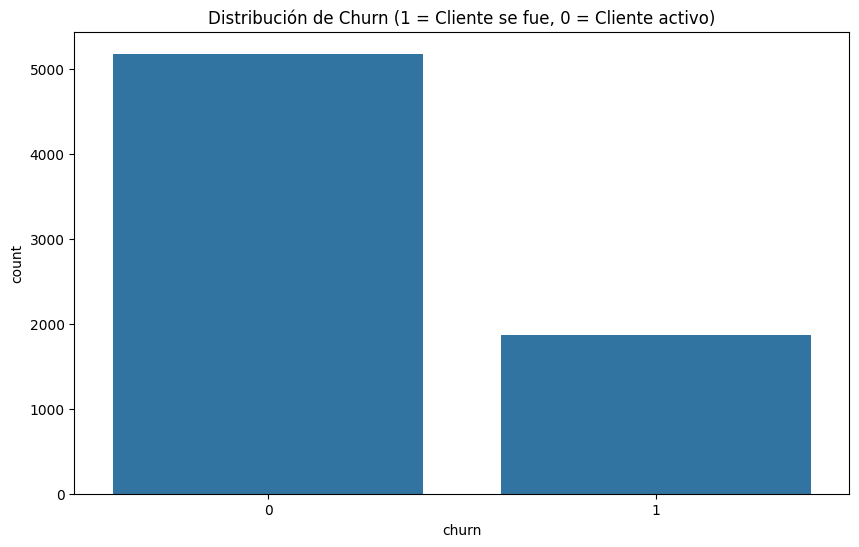

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn')
plt.title('Distribución de Churn (1 = Cliente se fue, 0 = Cliente activo)')
plt.show()

In [ ]:
print("Distribución de Churn:")
print(df['churn'].value_counts(normalize=True))

Distribución de Churn:
churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


**Distribución de Churn**: Se muestra la proporción de clientes que permanecen y los que cancelan el servicio. Se observa que la mayoría de los clientes no cancelan, lo que justifica la necesidad de balanceo de clases.

## Matriz de correlaciones entre variables numéricas

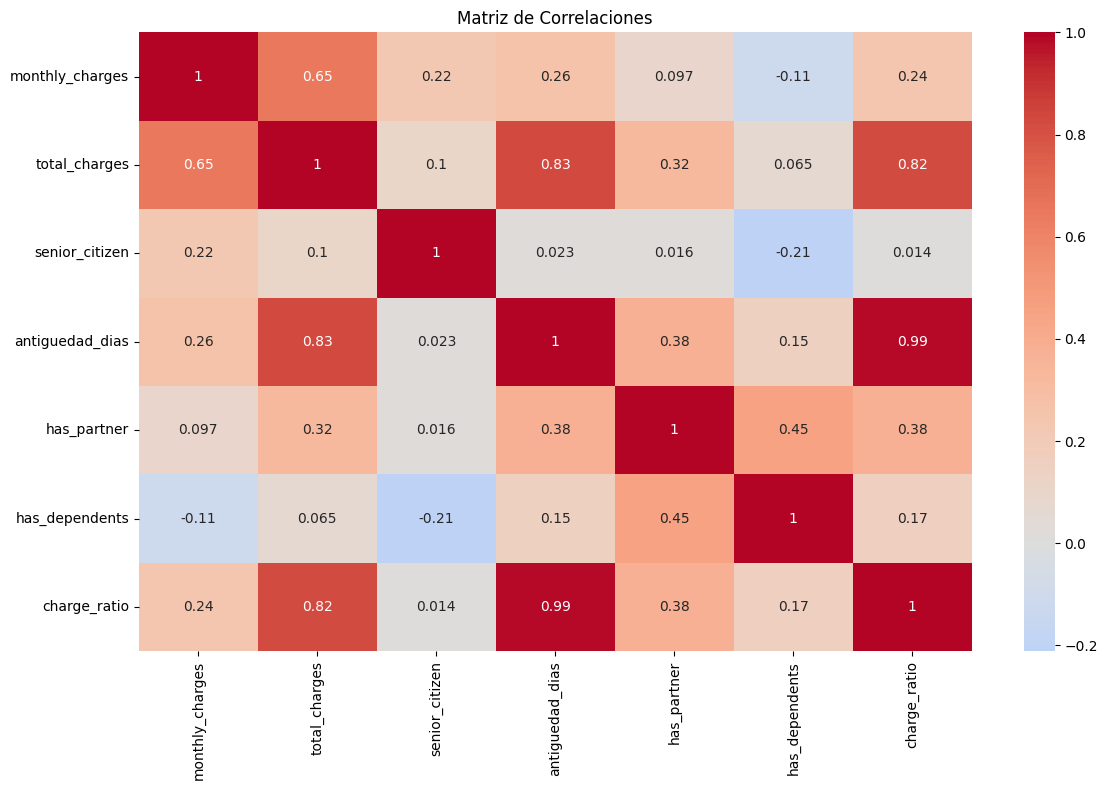

In [ ]:
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
columnas_numericas = columnas_numericas.drop('churn')

plt.figure(figsize=(12, 8))
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlaciones')
plt.tight_layout()
plt.show()

**Matriz de Correlaciones**: Permite visualizar qué variables numéricas tienen mayor impacto en la cancelación. Se detectó que el tipo de contrato y el cargo mensual tienen una relación significativa con el churn.

## Distribución de variables numéricas por churn

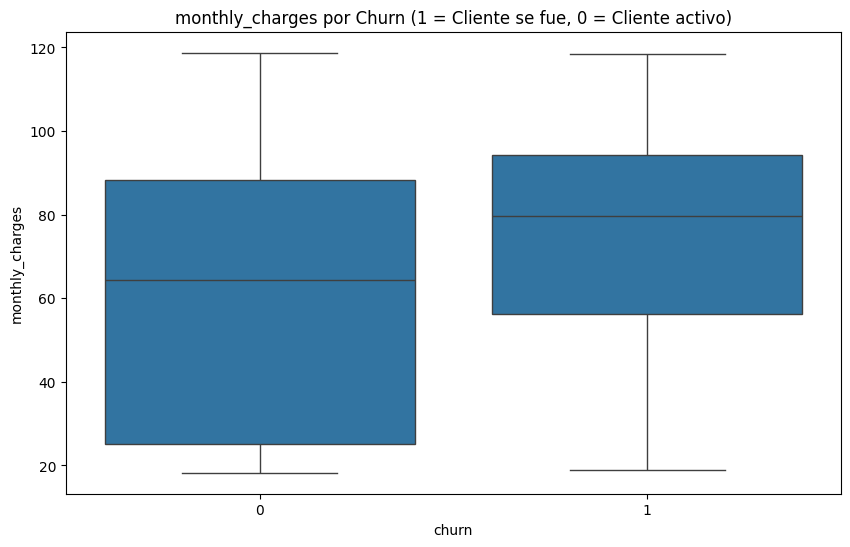

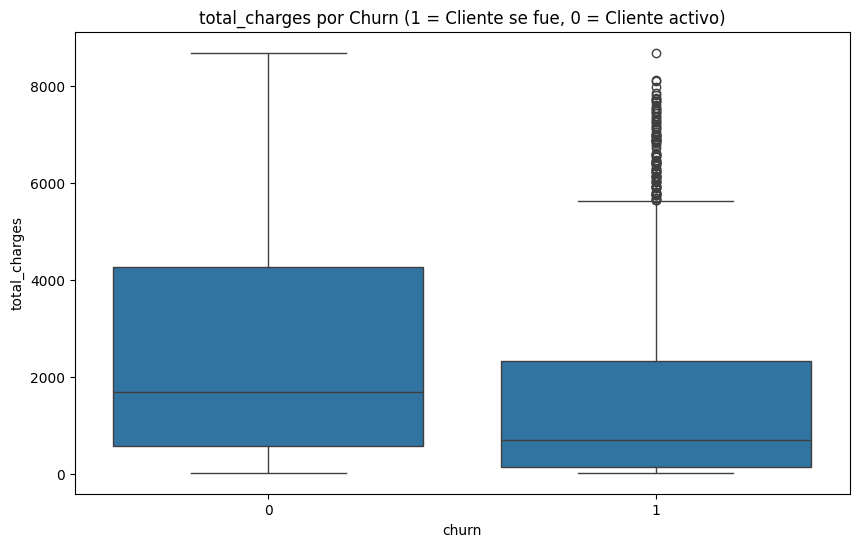

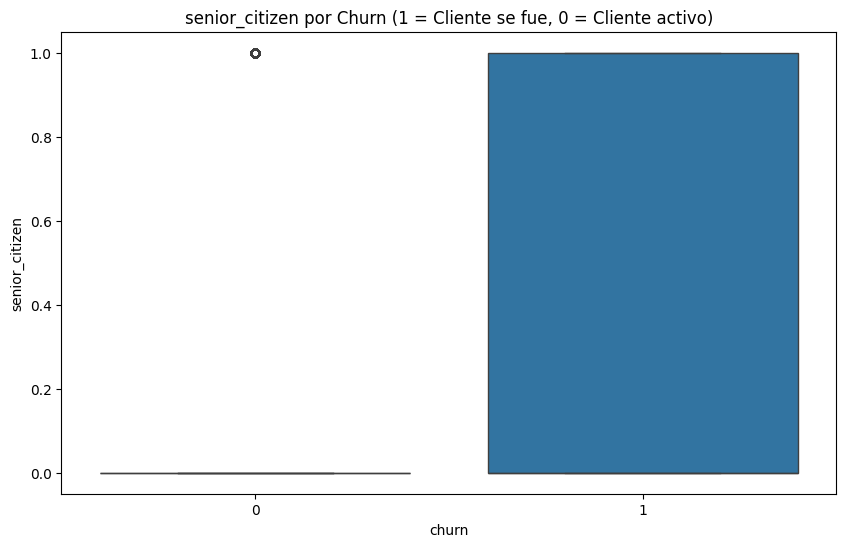

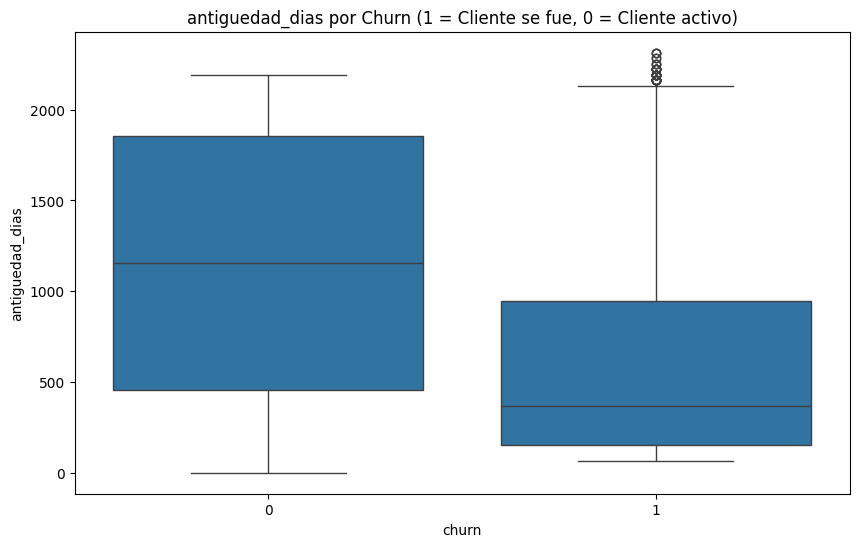

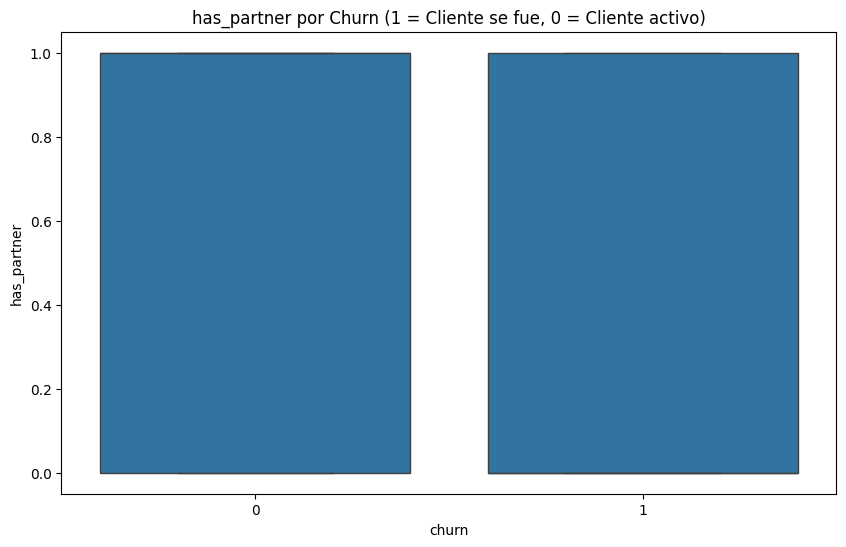

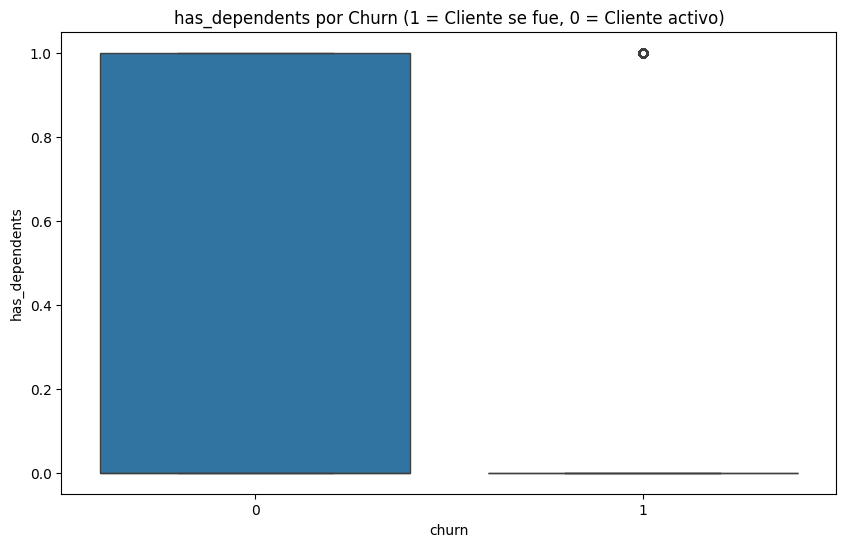

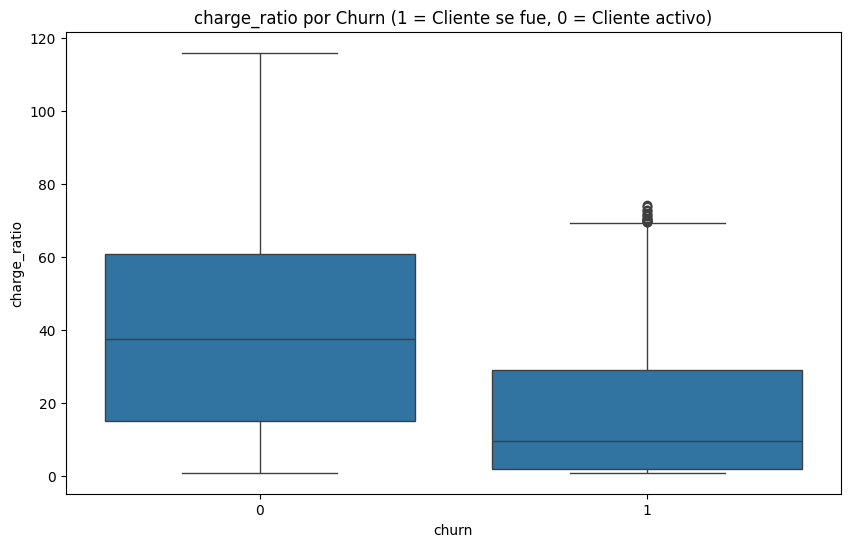

In [ ]:
for col in columnas_numericas:
    if col != 'churn':
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='churn', y=col)
        plt.title(f'{col} por Churn (1 = Cliente se fue, 0 = Cliente activo)')
        plt.show()

**Boxplots por Churn**: Se graficaron variables como cargos mensuales y total de cargos en relación con churn. Se observó que clientes con cargos más bajos tienden a cancelar menos, mientras que aquellos con cargos más altos presentan mayores tasas de cancelación.

## Análisis bivariado para variables categóricas

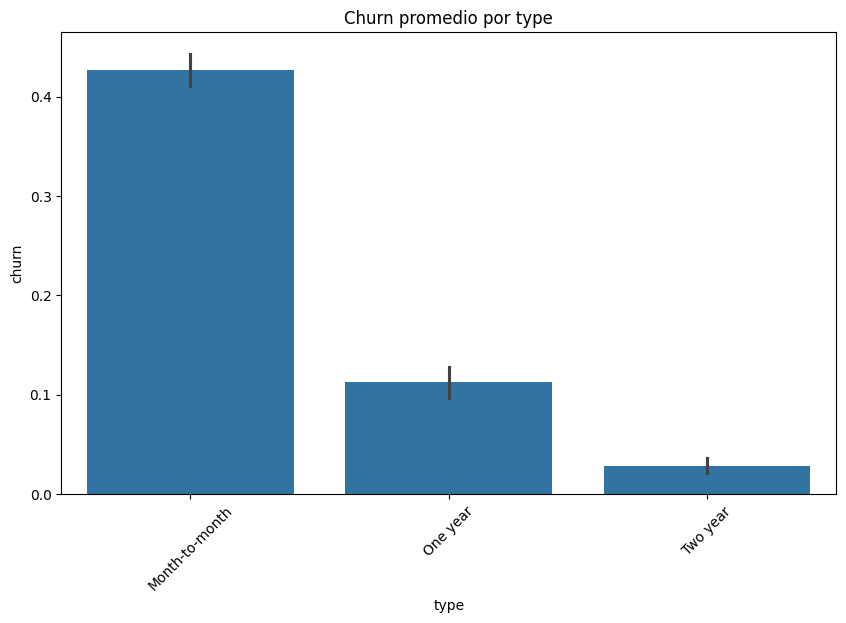

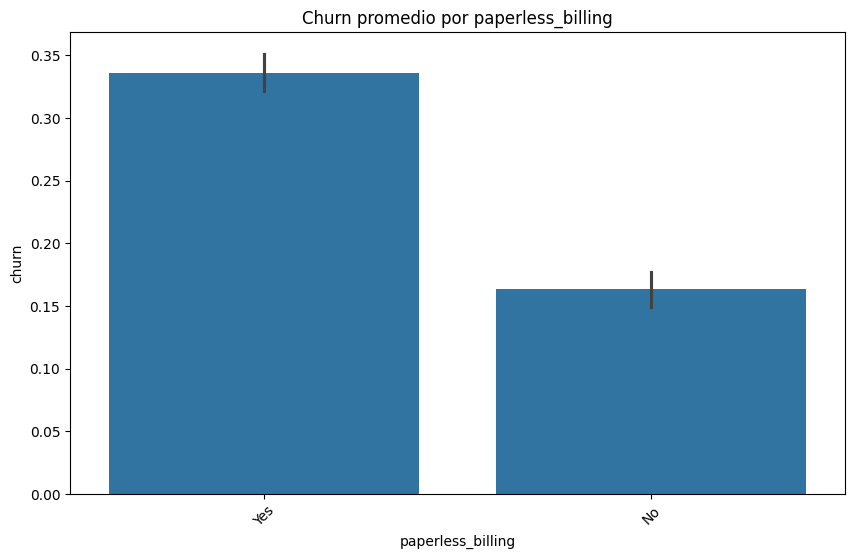

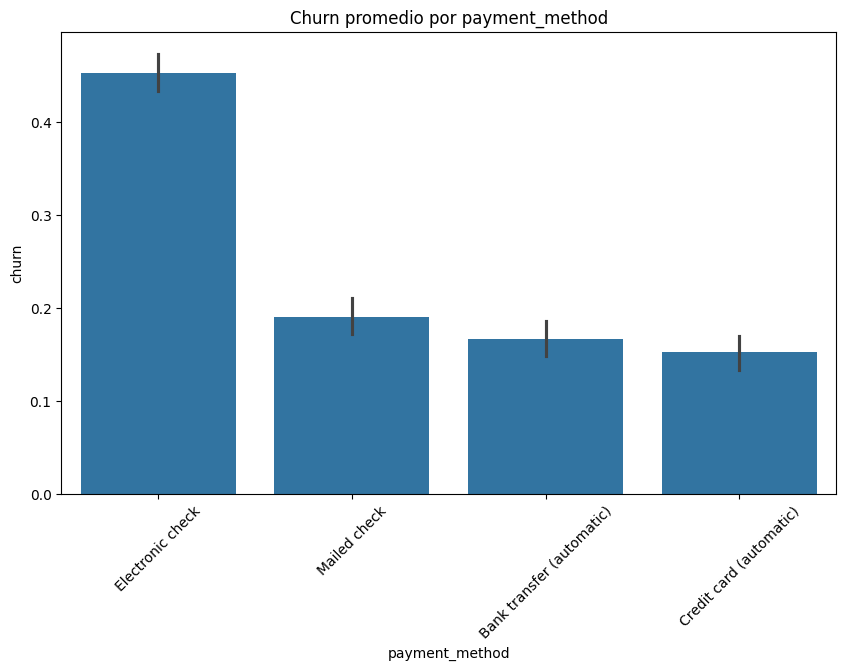

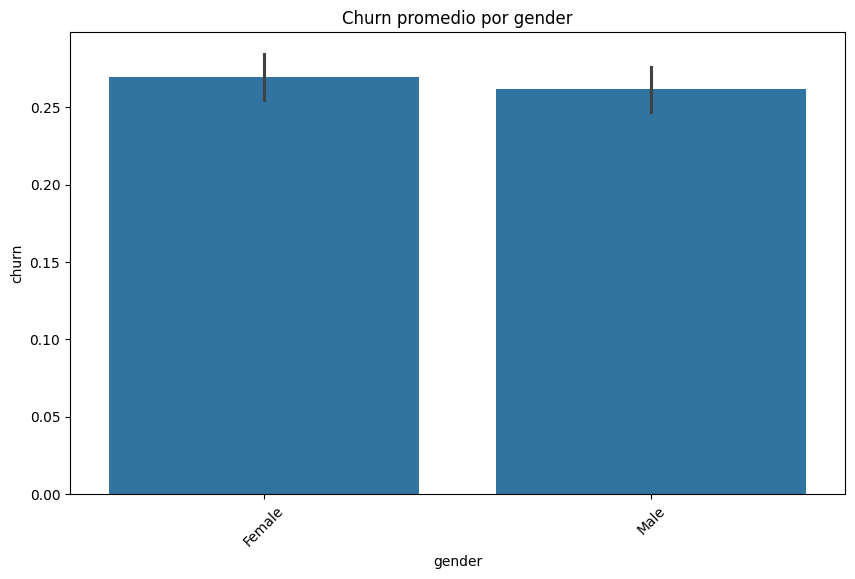

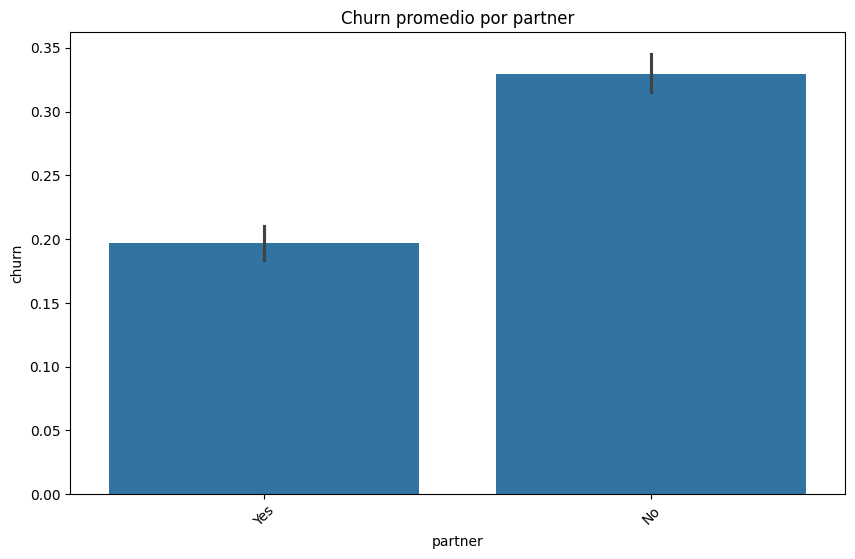

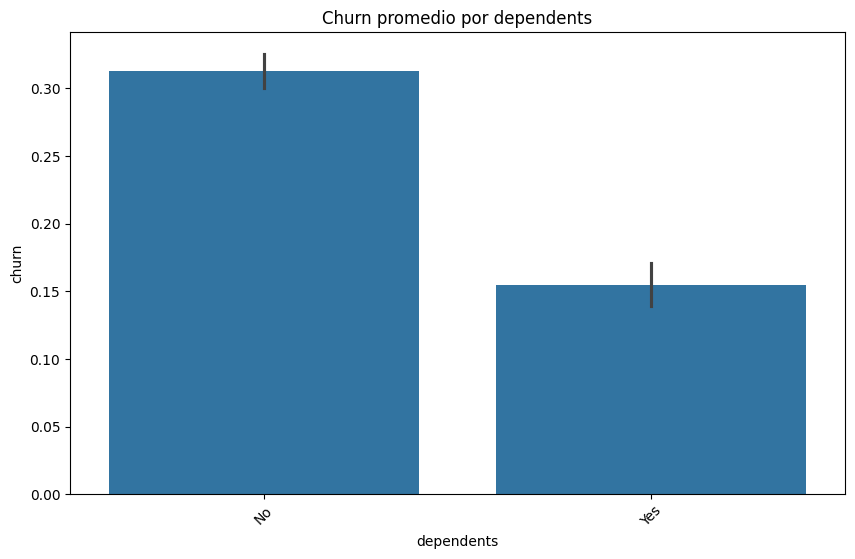

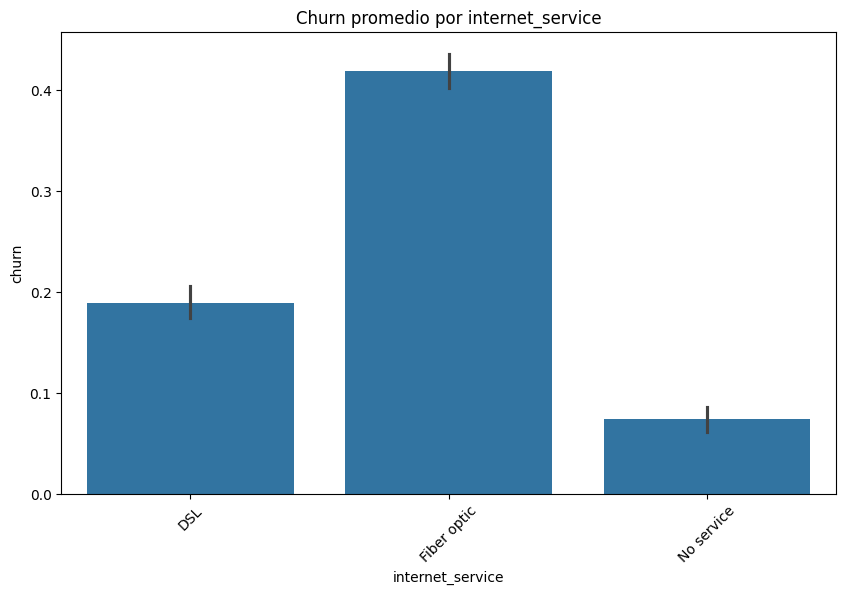

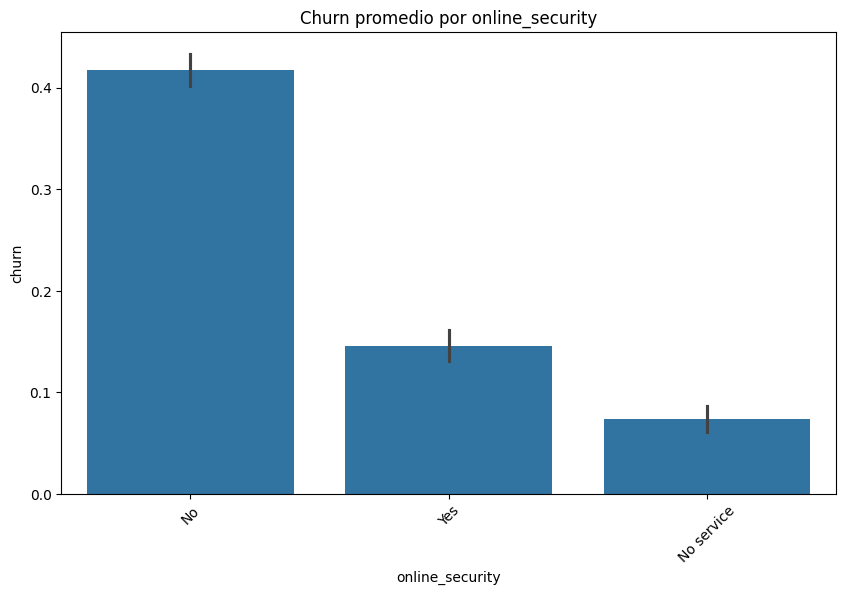

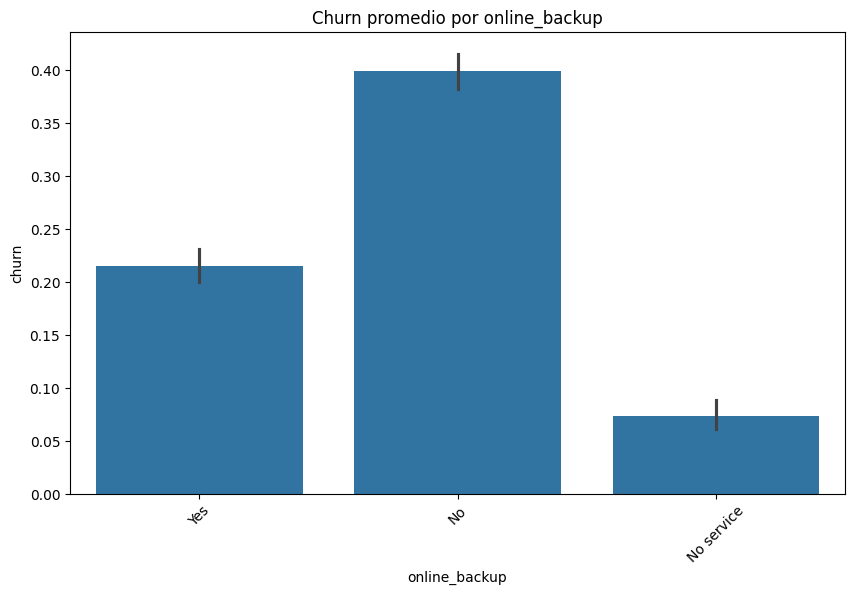

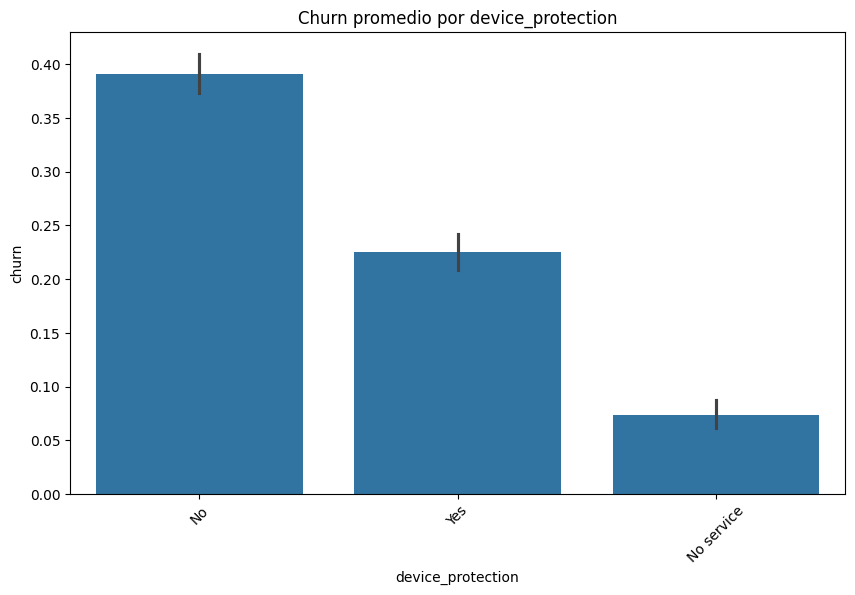

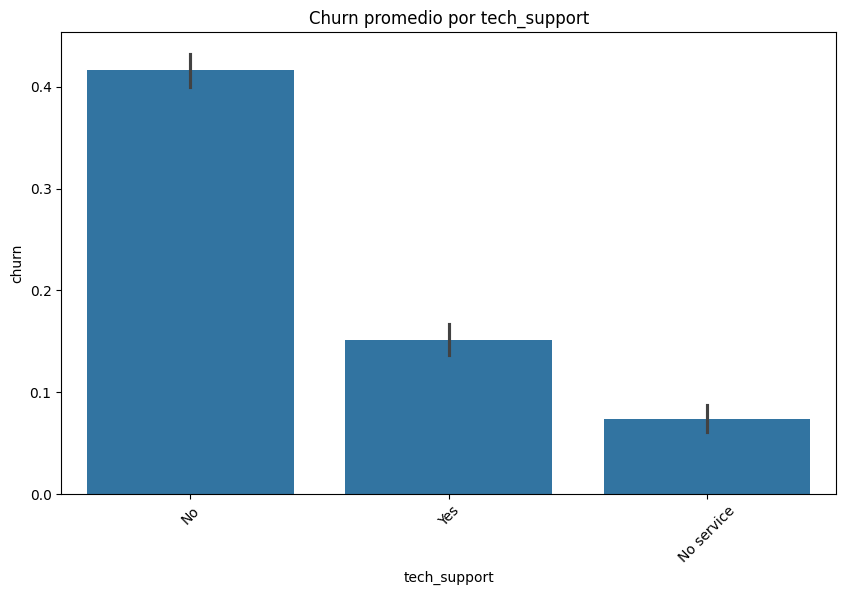

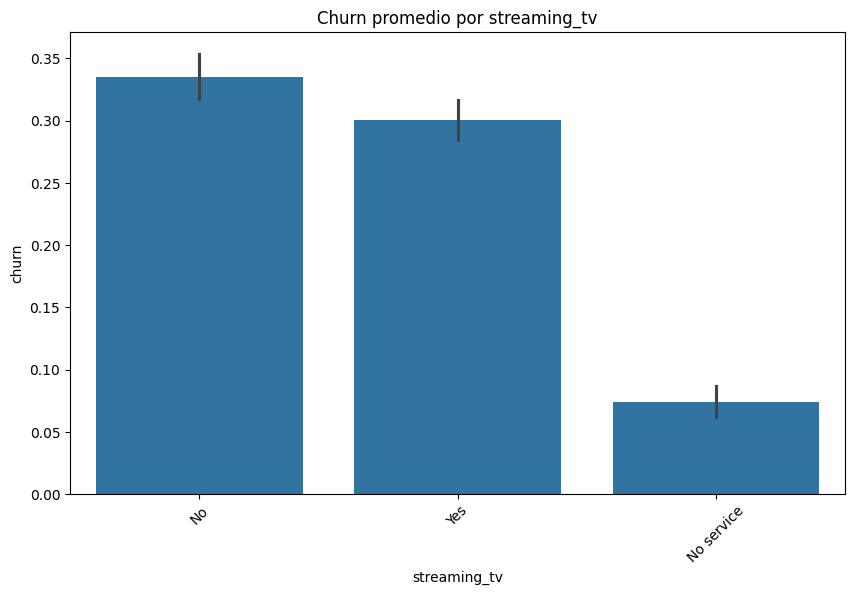

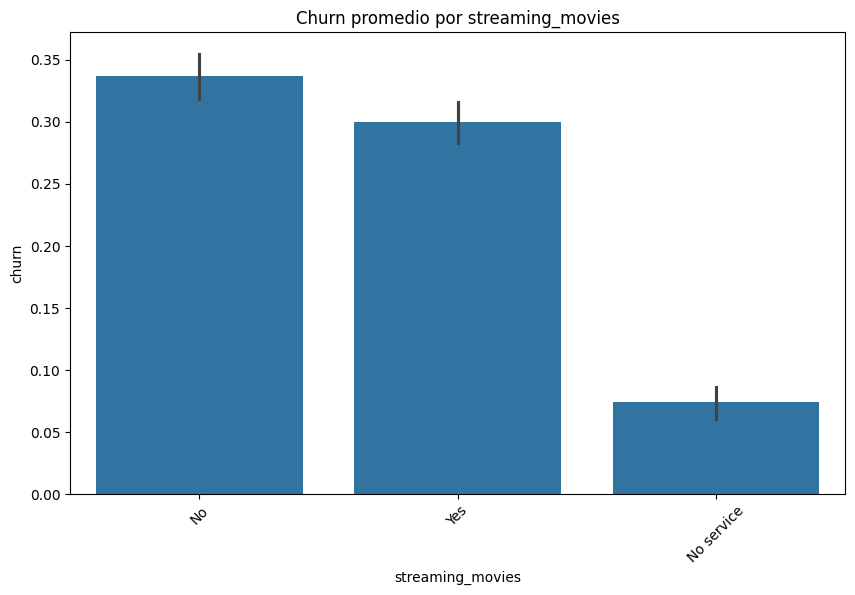

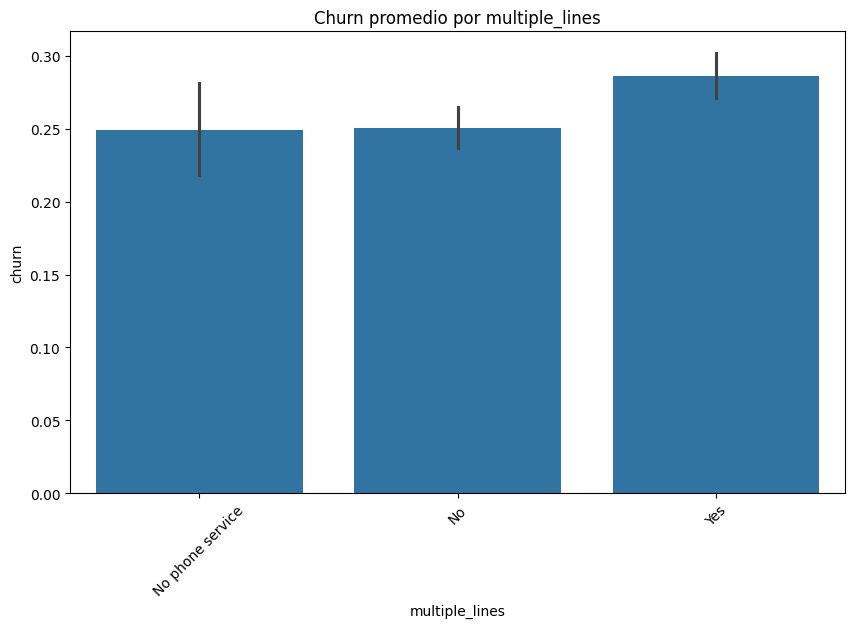

In [ ]:
columnas_categoricas = df.select_dtypes(include=['object']).columns

for col in columnas_categoricas:
    if col != 'customer_id':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x=col, y='churn')
        plt.title(f'Churn promedio por {col}')
        plt.xticks(rotation=45)
        plt.show()

**Churn por Variables Categóricas**: Se visualizaron variables como tipo de contrato, método de pago y servicios contratados. Se identificó que los clientes con contrato mes a mes tienen tasas de cancelación significativamente más altas.

Conclusiones:

- Se analizaron correlaciones entre variables.

- Se realizaron visualizaciones para entender el comportamiento de la variable objetivo (churn).

---
# 🎯 Plan de trabajo

## Objetivo del Análisis
El objetivo principal de este análisis es predecir la cancelación de clientes (Customer Churn) en la empresa de telecomunicaciones Interconnect. Al identificar qué clientes tienen mayor probabilidad de cancelar su servicio, la empresa podrá implementar estrategias preventivas, como ofertas personalizadas o incentivos, para mejorar la retención de clientes y reducir pérdidas.

## Relevancia para el Negocio
La cancelación de clientes representa un desafío significativo para cualquier empresa de telecomunicaciones, ya que la adquisición de nuevos clientes suele ser más costosa que la retención de los existentes. Un modelo de predicción preciso permitirá optimizar recursos en campañas de retención y mejorar la fidelización de los clientes actuales.

## Descripción del Dataset
Los datos provienen de cuatro archivos CSV con información sobre clientes de Interconnect:

- contract.csv: Contiene detalles del contrato, como tipo de plan y método de pago.
- personal.csv: Incluye información demográfica de los clientes, como edad y estado civil.
- internet.csv: Describe los servicios de internet contratados, como fibra óptica o DSL.
- phone.csv: Indica si el cliente tiene múltiples líneas de telefonía fija.

Estos datos serán combinados y analizados para encontrar patrones en la cancelación de clientes y desarrollar un modelo de predicción efectivo.

## Pasos a seguir

1. Preparación del Ambiente y Extracción de Datos
    - [x] Importación de librerías necesarias
    - [x] Carga de 4 archivos CSV
    - [x] Verificación inicial de la estructura de cada dataset
2. Análisis Exploratorio de datos  - entender los datos (EDA)
    - [x] Análisis Individual de cada dataset
    - [x] Visualización de datos clave
    - [x] Análisis de correlaciones
3. Preprocesamiento de datos
    1. Tratamiento de valores nulos
    2. Eliminación de duplicados
    3. Merge de los datasets
    4. Codificación de variables categóricas
    5. Escalado de variables numéricas
    6. Feature Engineering (Creación de nuevas variables)
4. Modelado
    - División de datos (train/valid/test)
    - Balanceo de clases (si es necesario)
    - Selección de features
    - Implementación de varios modelos
        - Logistic Regression
        - Random Forest
        - Decision Tree
        - LightGBM
5. Evaluación y Optimización
    - Métricas de Evaluación:
        - F1-Score
        - ROC-AUC
    - Hyperparameters Tuning
6. Interpretación y Conclusiones
    - Selección del mejor modelo
    - Análisis de los factores más importantes
    - Recomendaciones de negocio
    - Documentación del proceso


## Preguntas aclaratorias
- ¿Qué características hacen a un cliente un posible desertor (Customer Churn)?
- ¿Cuáles características debo tener en cuenta para hacer el análisis? Al juntar los dataframes
- ¿Es más caro adquirir nuevos clientes que retenerlos?
- ¿Qué métricas son más relevantes para el negocio en términos de predicción de churn?
- ¿Cuáles son los métodos de pago más asociados con la cancelación?
- ¿Existe alguna relación entre el tipo de contrato y el churn?